In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


np.random.seed(54865)

# 1. Dataset Cleanup

## Missing Data

* ### Replace with mean value

## Outliars Data

* ### Remove depend on z-score value
* ### Threshold for z-score is 1.8

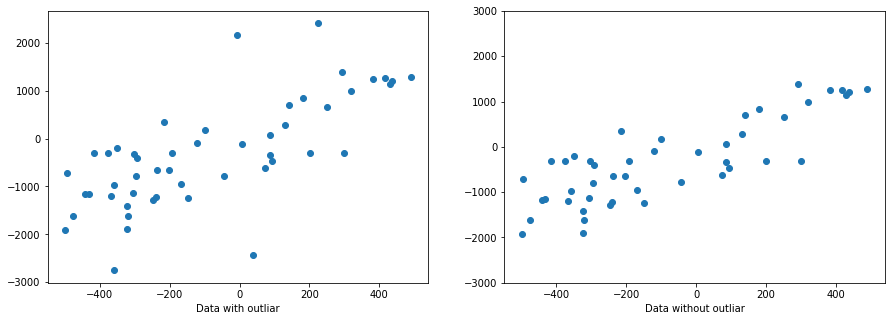

In [2]:
data = pd.read_csv('data.csv', header=None)


def missing_handle(data):

    new_data = pd.DataFrame()
    mean_data = data.mean()

    for i in data:
        new_data[i] = data[:][i].fillna(mean_data[i])
    return new_data

# Replcae missing value with mean


new_data = missing_handle(data)


X = new_data.iloc[:, :-1]
Y = new_data.iloc[:, -1]

plt.figure(figsize=(15, 5))
plt.ylim([-3000, 3000])
plt.subplot(1, 2, 1)
plt.xlabel('Data with outliar')
plt.scatter(X, Y)


def outliar_handle(data, threshold):

    Y_position = data.shape[1]-1
    zscore_y = (data[Y_position]-data.mean()[Y_position]) / data.std()[Y_position]

    new_data = pd.DataFrame()
    new_data = data[abs(zscore_y) < threshold]

    return new_data


# Remove Outliars using z_score threshold=1.8

new_data = outliar_handle(new_data, 1.8)
X = new_data.iloc[:, :-1]
Y = new_data.iloc[:, -1]


plt.subplot(1, 2, 2)
plt.ylim([-3000, 3000])
plt.scatter(X, Y)
plt.xlabel('Data without outliar')
plt.show()

# 2. Normalize Data

* ### I have used Z score formula to normalize data

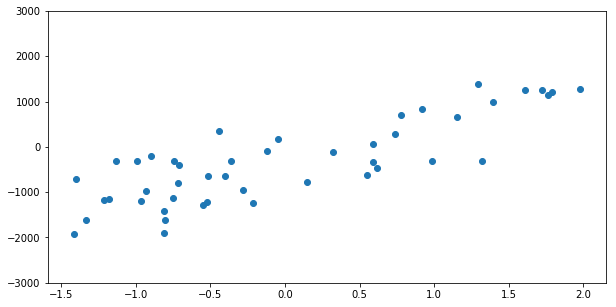

In [3]:
def z_normalize(data):
    new_data = pd.DataFrame()
    length = data.shape[1]

    for i in range(length-1):
        new_data[i] = (data[i]-np.mean(data[i]))/np.std(data[i])

    new_data[length-1] = data[length-1]
    return new_data

# Normalize Data with Z-Score


new_data_norm = z_normalize(new_data)

X = new_data_norm.iloc[:, :-1]
Y = new_data_norm.iloc[:, -1]

plt.figure(figsize=(10, 5))
plt.ylim([-3000, 3000])
plt.scatter(X, Y)
plt.show()

# 3. Split Data

* ### I have splited data into 4 section

In [4]:
def data_split(data, k):

    np.random.shuffle(data.values)

    length = data.values.shape[0]//k

    data_list = []
    initial = 0

    for i in range(1, k+1):
        if i == k:
            data_list.append(data.iloc[initial:].values)
        else:
            data_list.append(data.iloc[initial:i*length].values)
        initial = i*length
    return data_list


data_list = data_split(new_data_norm, 4)

#  4. Regression Analytical Solution

In [5]:
def regression(data):
    x = data[:, :-1]
    y = data[:, -1:]
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    x_difference = (x-x_mean)
    y_difference = (y-y_mean)

    m = np.matmul(x_difference.T, y_difference)/sum(x_difference**2)

    b = y_mean - m*x_mean

    return m, b


def reg_r2_score(data, m, b):
    x = data[:, :-1]
    y = data[:, -1:]
    y_mean = np.mean(y)
    y_pred = m*x+b
    return float(1-sum((y-y_pred)**2)/sum((y-y_mean)**2))*100


index = np.arange(4)
best_m, best_c, best_acc = 0, 0, 0
avg_ac = 0

for i in index:

    train = [data_list[j] for j in index[index != i]]

    train_data = np.concatenate([*train], axis=0)
    val_data = data_list[i]

    m, b = regression(train_data)

    accuracy = reg_r2_score(val_data, m, b)
    avg_ac += accuracy
    best_m, best_c, best_acc = (m, b, accuracy) if accuracy > best_acc else (best_m, best_c, best_acc)

    print('Part {} for testing = {:.2f}%'.format(i+1, accuracy), end="\n\n")


print('Best Value for c & m = {} {}'.format(best_c, best_m))
print('Best Accuracy        = {:0.2f}%'.format(best_acc))
print('Average Accuracy     = {:0.2f}%'.format(avg_ac/4))

Part 1 for testing = 87.60%

Part 2 for testing = 70.20%

Part 3 for testing = 73.55%

Part 4 for testing = 51.51%

Best Value for c & m = [[-338.12845837]] [[747.05382461]]
Best Accuracy        = 87.60%
Average Accuracy     = 70.71%


# 5. Regression Gradient Descent
* ### Learning rate alpha = 0.001 have used

Part 1 for testing = 87.60%
Part 2 for testing = 70.20%
Part 3 for testing = 73.55%
Part 4 for testing = 51.51%
Best Value for theta = [[-338.12845837  747.05382461]]
Best Accuracy        = 87.60%
Average Accuracy     = 70.71%


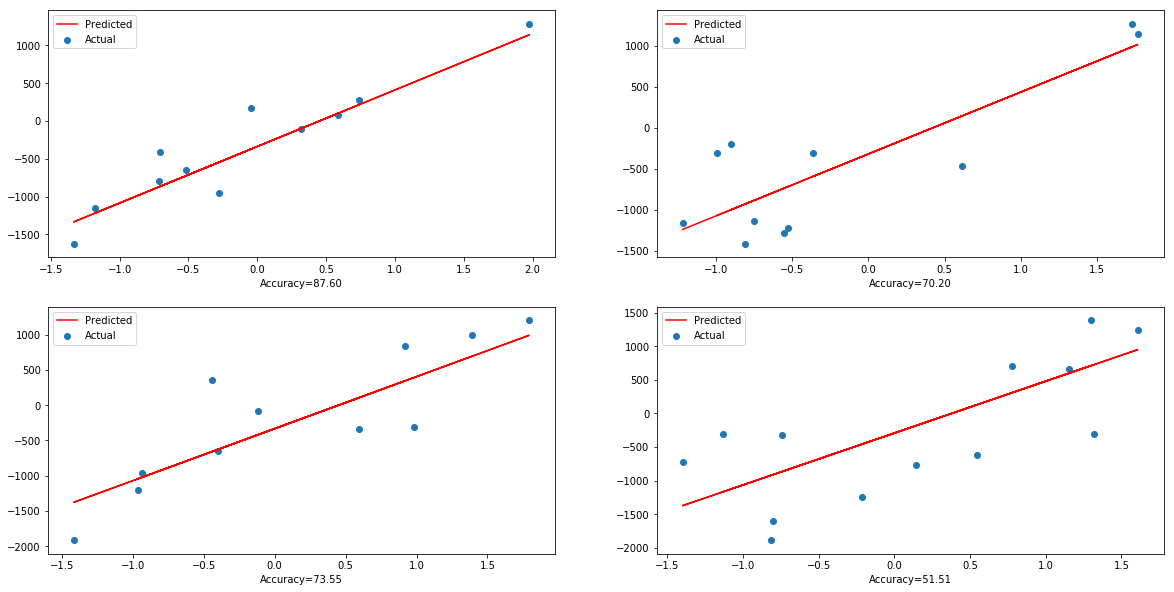

In [6]:
def xy_split(data):
    '''
        1. Divide data into 2 section X & Y
        2. Padding 1 at first position of each row in X 
    '''
    length = data.shape[0]
    x = np.concatenate([np.ones((length, 1)), data[:, :-1]], axis=1)
    y = data[:, -1:]

    return (x, y)


def predict(x, theta):

    return np.matmul(x, theta.T)


def grad(x, y, theta, epoch):

    for i in range(epoch):

        y_pred = predict(x, theta)
        error = y_pred - y

        dif = np.matmul(error.T, x)
        dif = (0.001*dif/error.shape[0])

        theta -= dif

    return theta


def r2_score(x, y, theta):

    y_mean = np.mean(y)
    pred = predict(x, theta)

    up = sum((y-pred)**2)
    down = sum((y-y_mean)**2)

    accuracy = float(1 - up/down)

    return accuracy*100


plt.figure(figsize=(20, 10))
best_theta, best_accuracy, avg_ac = np.array([]), 0, 0

# Data split into 4 section

index = np.arange(4)

for i in index:

    train = [data_list[j] for j in index[index != i]]

    train_data = np.concatenate([*train], axis=0)
    val_data = data_list[i]

    X_train, Y_train = xy_split(train_data)
    X_test, Y_test = xy_split(val_data)

    theta = np.random.rand(2).reshape(1, 2)

    theta = grad(X_train, Y_train, theta, 100000)

    accuracy = r2_score(X_test, Y_test, theta)

    avg_ac += accuracy
    print('Part {} for testing = {:0.2f}%'.format(i+1, accuracy))
    best_accuracy, best_theta = (accuracy, theta) if best_accuracy < accuracy else (best_accuracy, best_theta)

    plt.subplot(2, 2, i+1)

    plt.plot(X_test[:, 1], predict(X_test, theta), c='r', label="Predicted")
    plt.scatter(X_test[:, 1], Y_test, label="Actual")
    plt.legend()
    plt.xlabel('Accuracy={:.2f}'.format(accuracy))


print('Best Value for theta = {}'.format(best_theta))
print('Best Accuracy        = {:0.2f}%'.format(best_accuracy))
print('Average Accuracy     = {:0.2f}%'.format(avg_ac/4))

plt.show()

## 6. Learning Parmeter Value for Model Performance

### Parameter value
* Alpha = 0.001
* Theta = [[-338.12845837  747.05382461]] 
    * where,
        * c = -338.12845837
        * m = 747.05382461
        
### Model Performance
* Average Accuracy = 70.71%
* Best Accuracy    = 87.60%

### Approach

* Data splited into 4 section
* 3 out of 4 selected for Train & rest section selected for Test
* Train model for every possible combination of 3 section out of 4